In [21]:
import numpy as np   
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#models
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,auc



# Data processing 

In [22]:
def violin_plot(nrow=4,ncol=2): 
    """
    funtion to plot violin plot for all attributes
    
    input : optional input for number of column and rows for subplot by default value are 2,4 respectively
    
    output : violin plot for all attribute of dataframe 
    
    return : none
    """
    fig = plt.figure(figsize=(14,25))
    fig.tight_layout(pad=3.0)
    nrow,ncol,index=4,2,1    
    for attribute in attributes:
        plt.subplot(nrow, ncol, index)
        plt.title(attribute)
        sns.violinplot(x="Outcome", y=attribute, data=data)
        index+=1
    plt.show()
        
def plot_auc(fpr,tpr,auc_model):
    """This function pots the ROC curve with help of False positive rate
    and True positive rate and auc object
    
    input : false positive rate, ture positive rate,auc of model
    
    output : ROC plot 
    
    return : None
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_model))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
 

# calculation of median for each attribute for both possible outcome  
def median_target(attribute):
    """
    This function replaces the Nan of given attribute with 
    median when grouped by Outcome into the global variable 
    data("dataframe")
    
    input : attribute 
    
    output : column of that attibute is modified 
    
    return : none
    """
    temp = data[data[attribute].notnull()]# assigning non null value to temp 
    temp = temp[[attribute, 'Outcome']].groupby(['Outcome'])[[attribute]].mean().reset_index() #calculate mean for a attribute with either 0 or 1 outcome 
    mean_op_0=temp[attribute][0]
    mean_op_1=temp[attribute][1]
    data.loc[(data['Outcome'] == 0 ) & (data[attribute].isnull()), attribute] = mean_op_0 #assigning mean to null values 
    data.loc[(data['Outcome'] == 1 ) & (data[attribute].isnull()), attribute] = mean_op_1

def median_target_all():
    # calling meadian_target for each attribute
    for attribute in attributes:
            median_target(attribute) 
        
def outliers_removal():
    """
    This function removes outlier of the global variable data(dataframe)
    using IQR method 
    """
    #loop for replacing outlier of all attribute with Nan value 
    for attribute in attributes:
        q1 = data[attribute].quantile(0.25)
        q3 = data[attribute].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        data.loc[(data[attribute] < fence_low) | (data[attribute] > fence_high),attribute]=np.nan

        
def z_score(df):
    """Function for apply z score standardization
       Input: dataframe to be standardized
       output :standardized dataframe 
    """
    df_std = df.copy()
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()     
    return df_std



In [23]:
data = pd.read_csv("diabetes.csv")
attributes = data.drop("Outcome",axis=1).columns

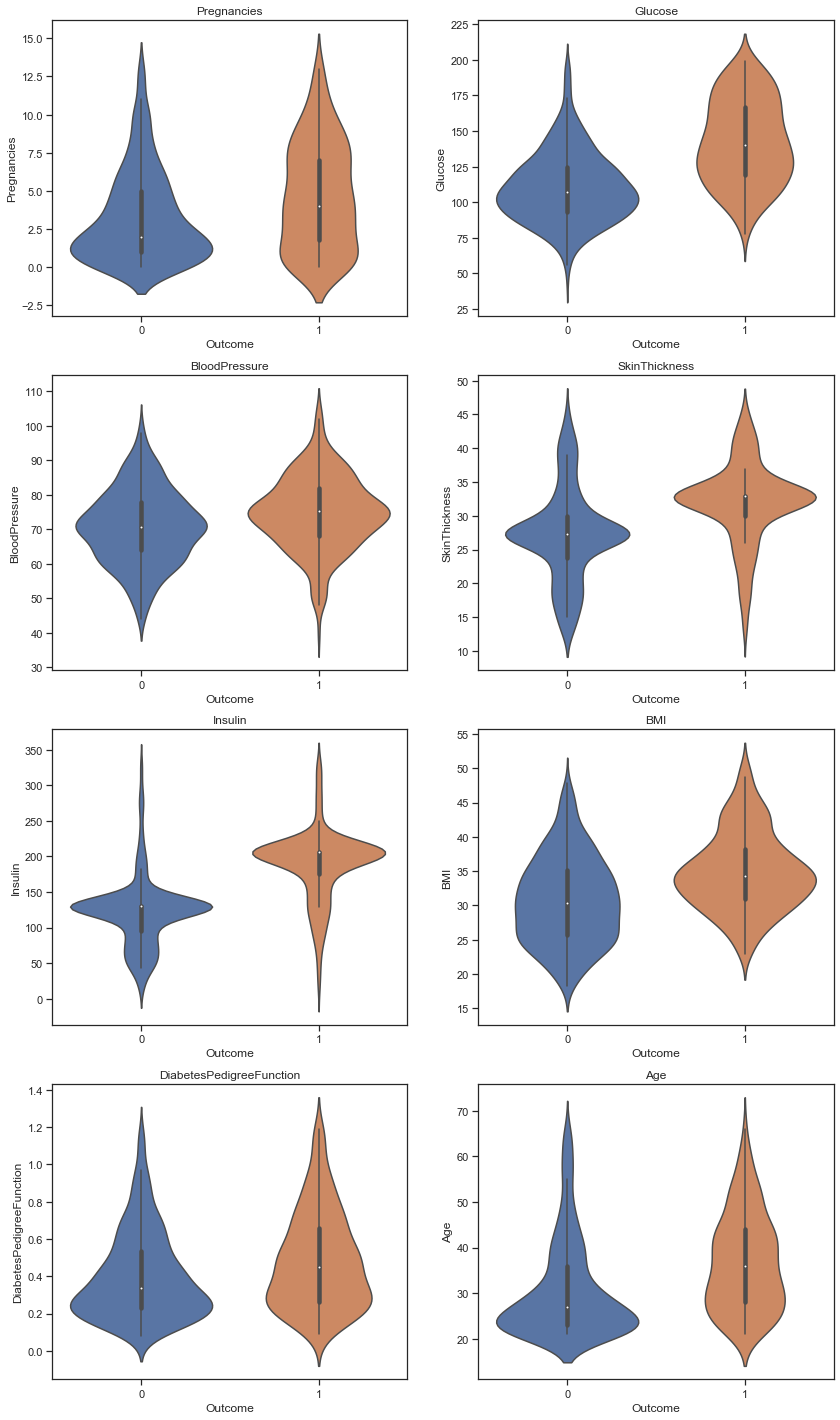

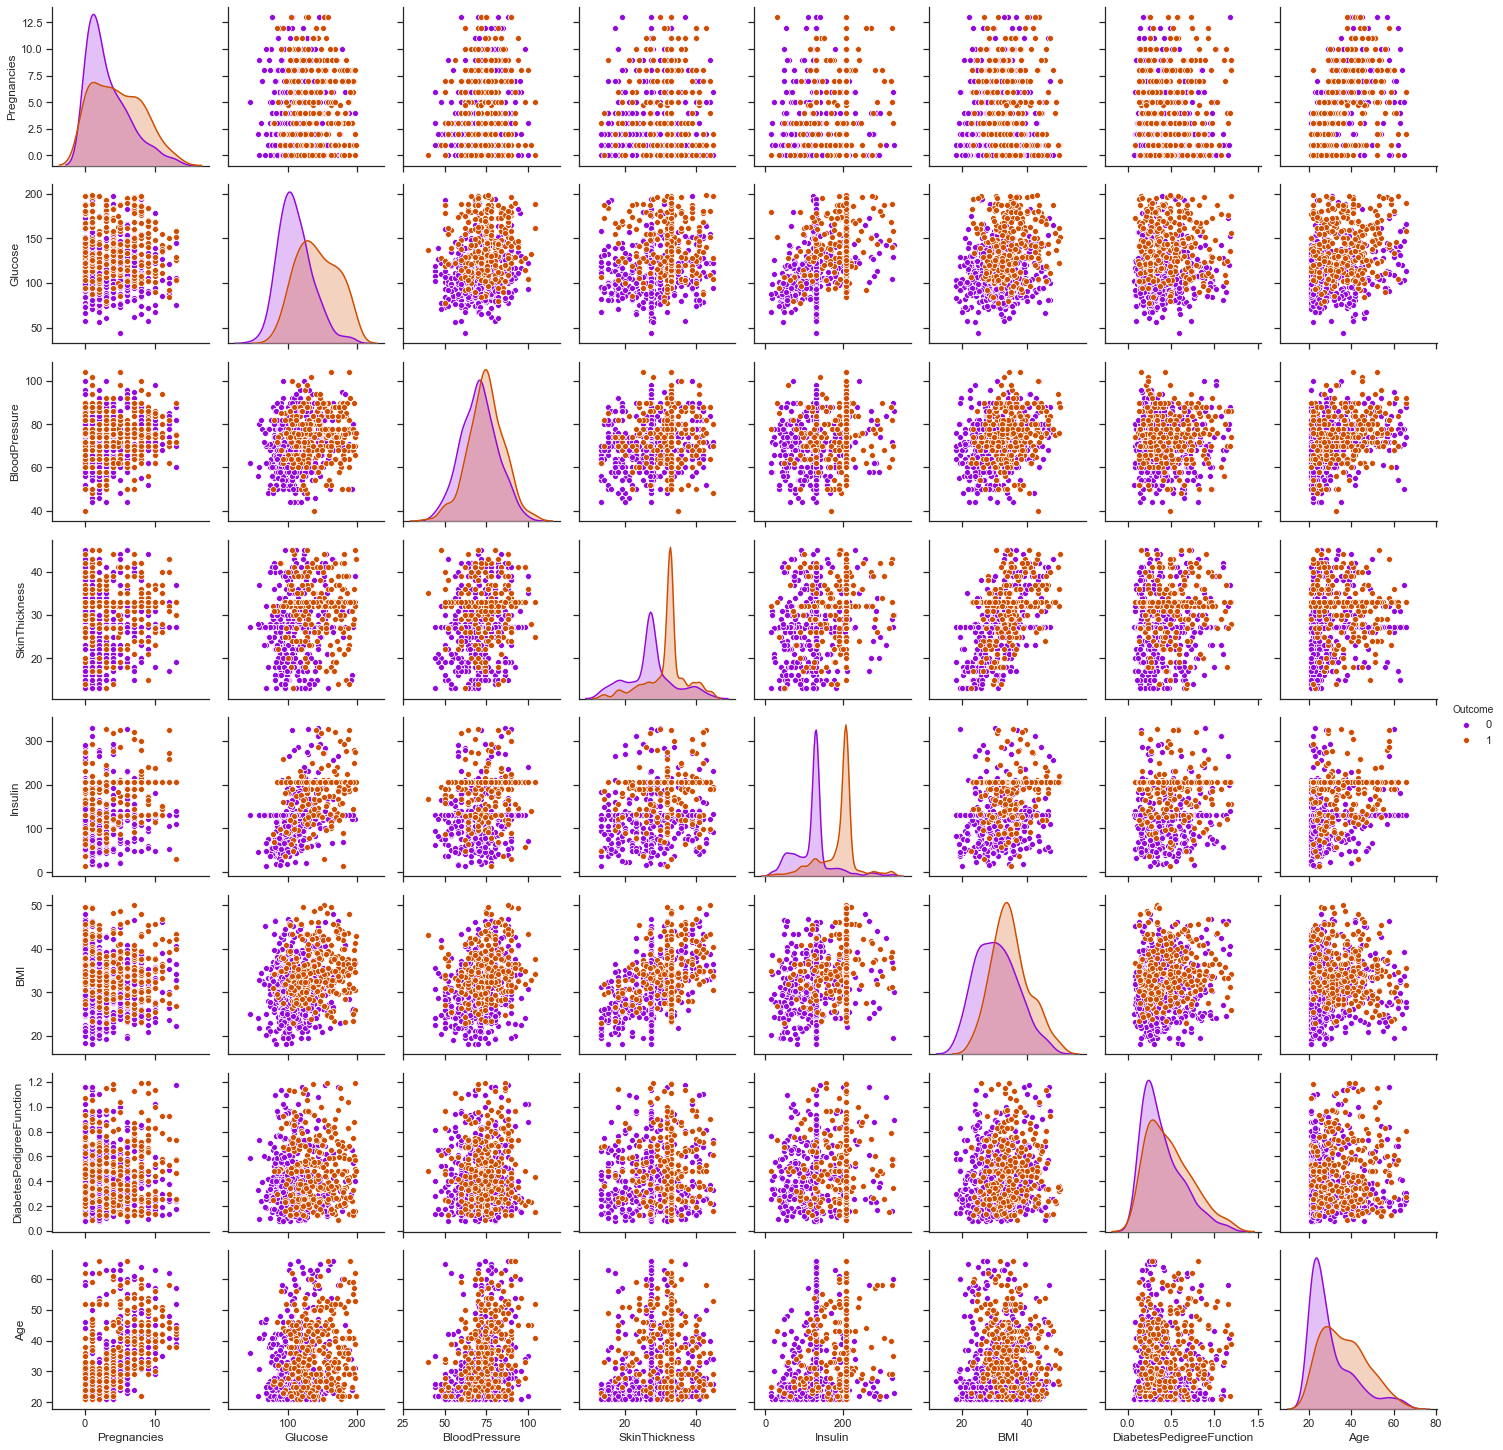

In [29]:
violin_plot()
sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');


In [25]:
# replacing missing value with nan value
data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]]=data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.nan)
median_target_all()

outliers_removal()
median_target_all()


In [26]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


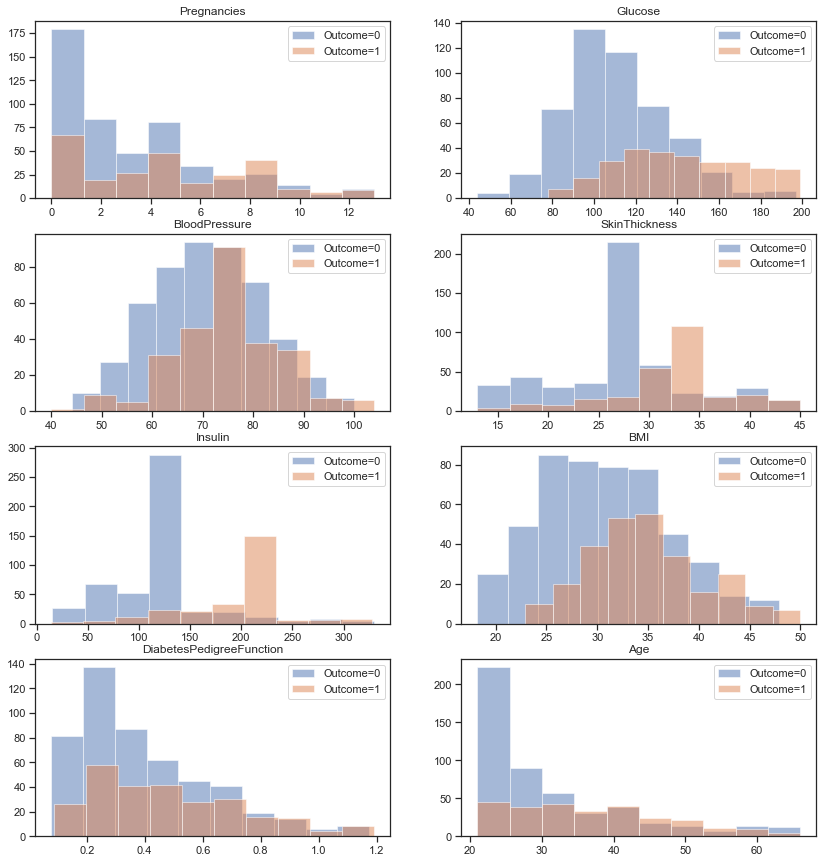

In [27]:
fig = plt.figure(figsize=(14,15))
fig.tight_layout(pad=3.0)
nrow,ncol,index=4,2,1    
for attribute in attributes:
    plt.subplot(nrow, ncol, index)
    plt.title(attribute)
    plt.hist(data[attribute][data.Outcome==0],alpha=0.5,label="Outcome=0")
    plt.hist(data[attribute][data.Outcome==1],alpha=0.5,label="Outcome=1")
    plt.legend(loc="best")
    index+=1
plt.show()


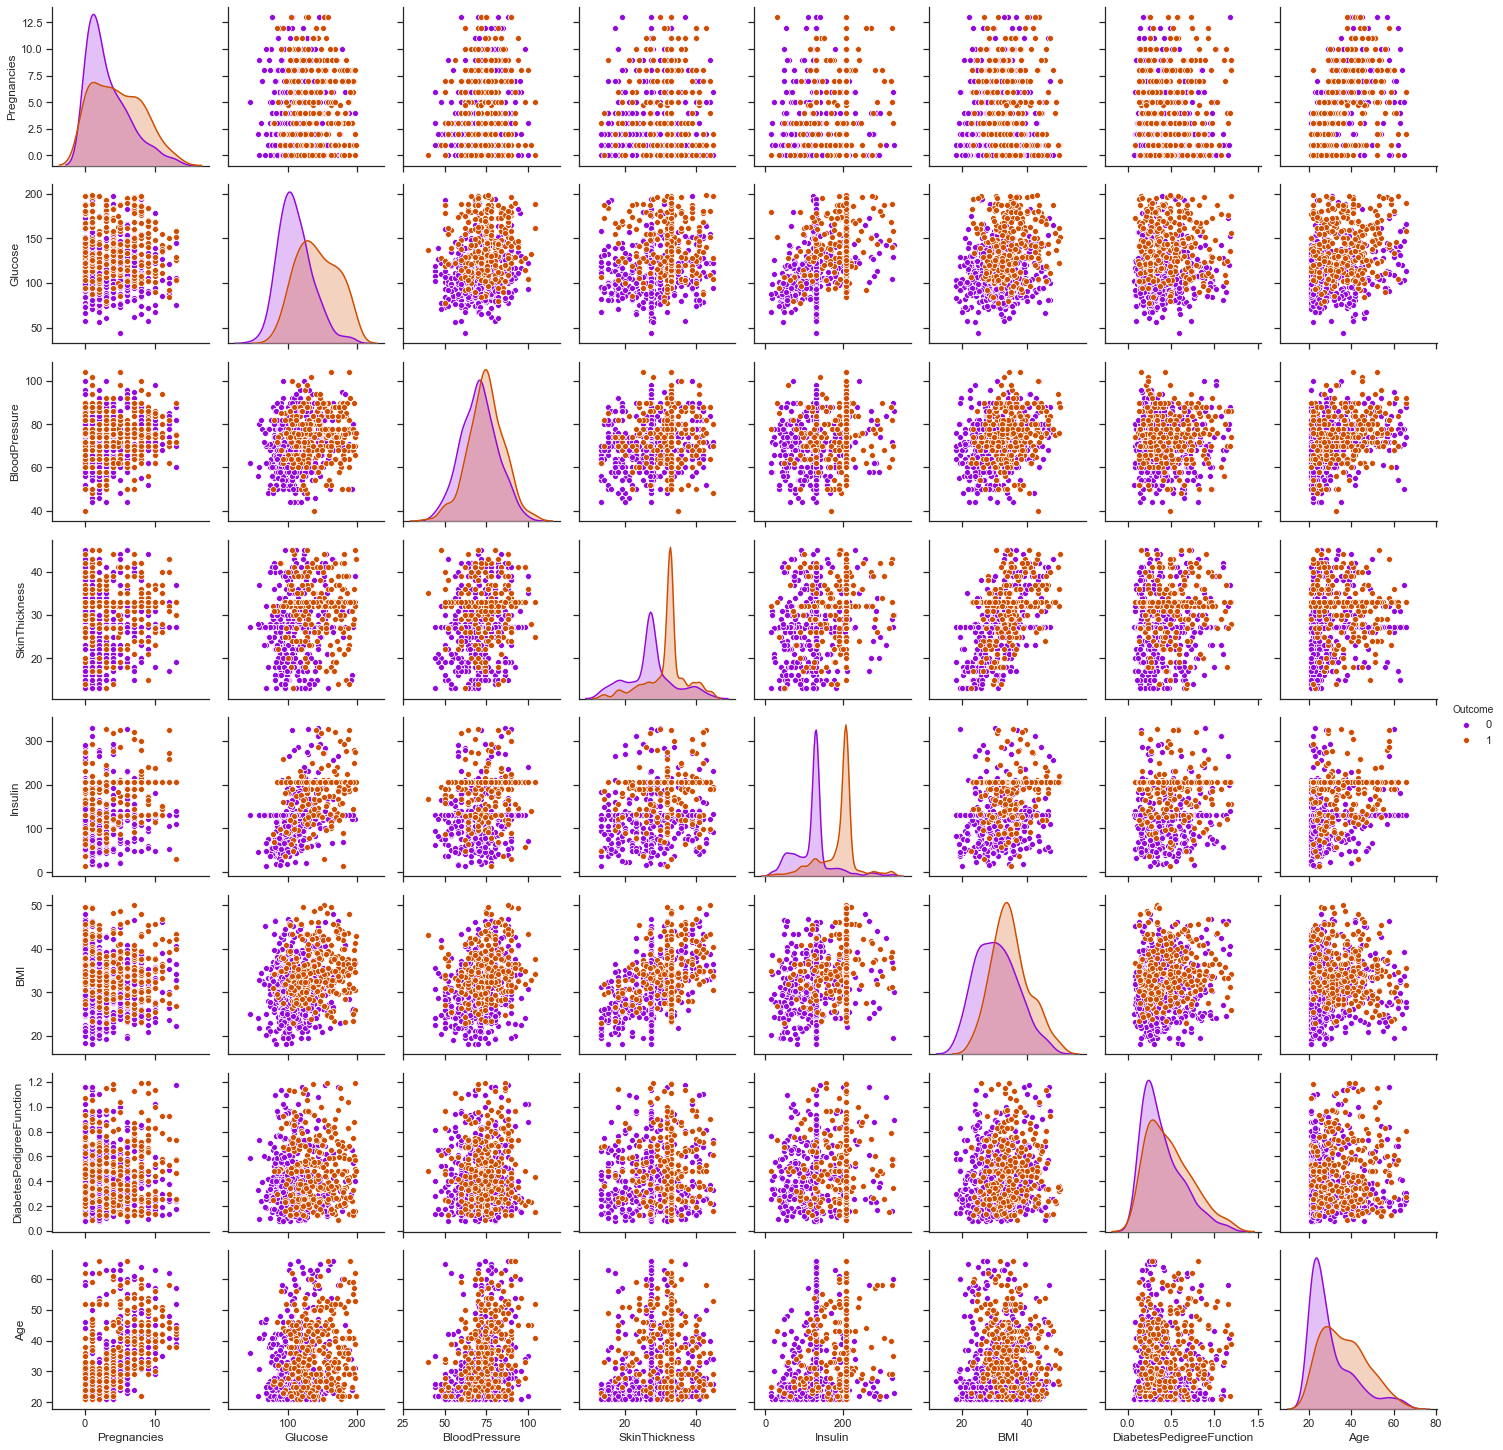

In [28]:

sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');


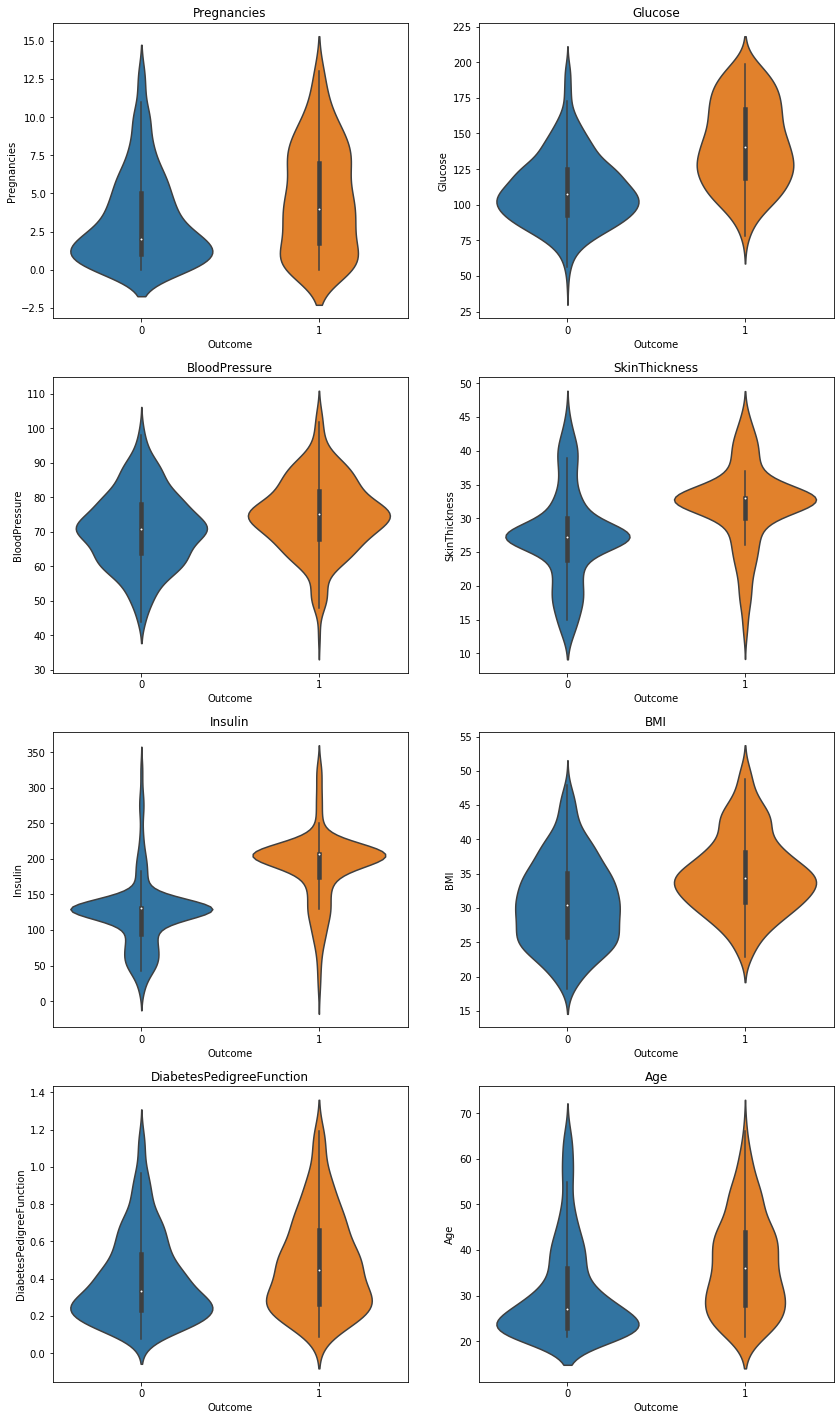

In [9]:
violin_plot()

In [10]:
# standardization of dataset
data_std=z_score(data)

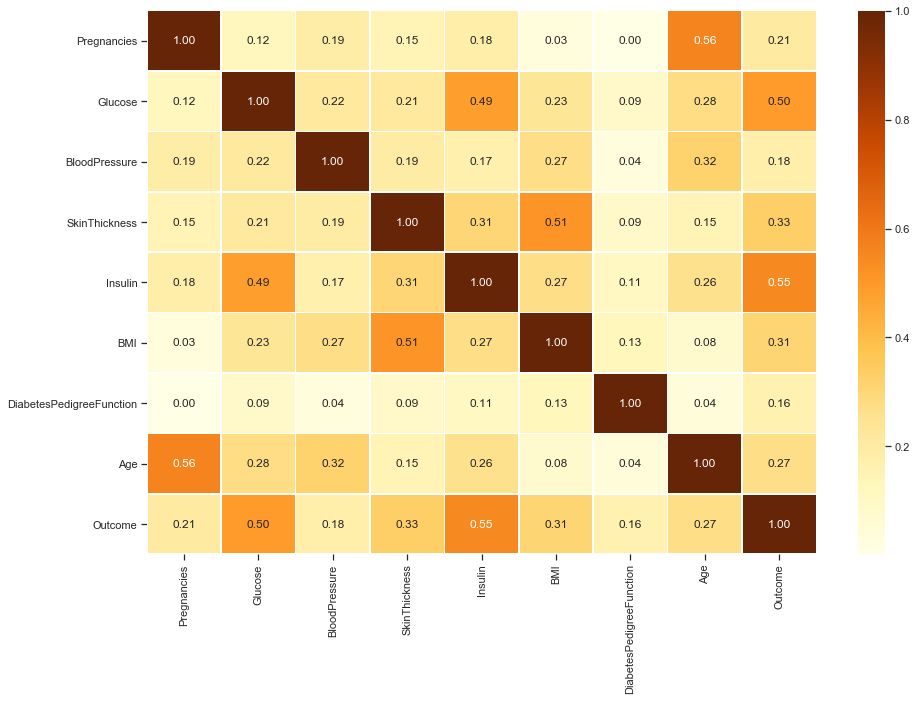

In [33]:
# It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data_std.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="YlOrBr")

###### Distribution of data set 

In [12]:
y = data["Outcome"]
X=data_std.drop("Outcome",axis=1)
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)


# Models 

In [63]:
"""from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
list_of_algo=[SVC(),AdaBoostClassifier(), 
              RandomForestClassifier(),
              LogisticRegression(),KNeighborsClassifier()]
name_of_algo=["SVM","AdaBoostClassifier", 
              "RandomForestClassifier",
              "LogisticRegression","KNeighborsClassifier"]
for i,algorithm in enumerate(list_of_algo):
    steps = [('pca', PCA(n_components=6)), ('m', algorithm)]
    model = Pipeline(steps=steps)
# evaluate model
    model_score = cross_val_score(model, X, y, scoring='accuracy', n_jobs=-1, error_score='raise')
    print("*"*120)
    print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))"""

'from sklearn.decomposition import PCA\nfrom sklearn.pipeline import Pipeline\nlist_of_algo=[SVC(),AdaBoostClassifier(), \n              RandomForestClassifier(),\n              LogisticRegression(),KNeighborsClassifier()]\nname_of_algo=["SVM","AdaBoostClassifier", \n              "RandomForestClassifier",\n              "LogisticRegression","KNeighborsClassifier"]\nfor i,algorithm in enumerate(list_of_algo):\n    steps = [(\'pca\', PCA(n_components=6)), (\'m\', algorithm)]\n    model = Pipeline(steps=steps)\n# evaluate model\n    model_score = cross_val_score(model, X, y, scoring=\'accuracy\', n_jobs=-1, error_score=\'raise\')\n    print("*"*120)\n    print(\'Accuracy of {} : {} \'.format(name_of_algo[i],(model_score.mean()*100)))'

************************************************************************************************************************
AUC of SVM : 0.8834615384615384 
Accuracy of SVM : 89.91111111111113 
Precision of SVM : 84.44444444444444 
Recall of SVM : 76.0 


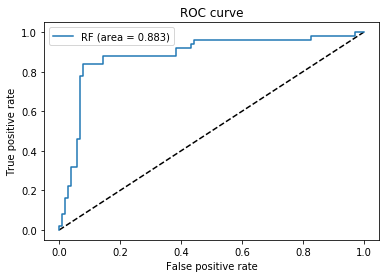

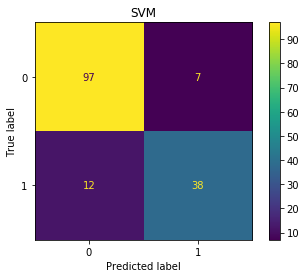

************************************************************************************************************************
AUC of AdaBoostClassifier : 0.9451923076923077 
Accuracy of AdaBoostClassifier : 94.64045584045584 
Precision of AdaBoostClassifier : 84.44444444444444 
Recall of AdaBoostClassifier : 76.0 


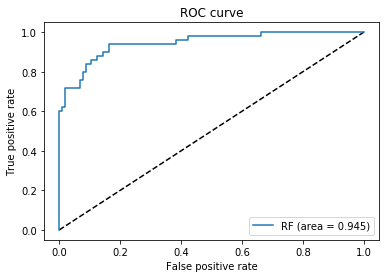

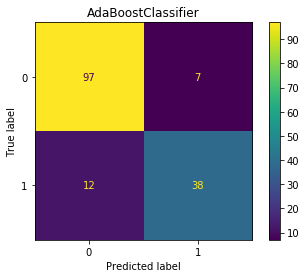

************************************************************************************************************************
AUC of RandomForestClassifier : 0.9547115384615386 
Accuracy of RandomForestClassifier : 94.94786324786325 
Precision of RandomForestClassifier : 84.78260869565217 
Recall of RandomForestClassifier : 78.0 


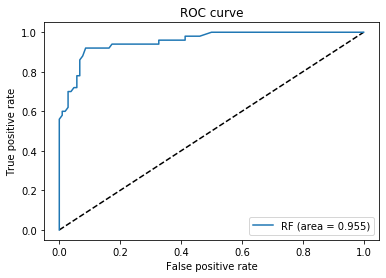

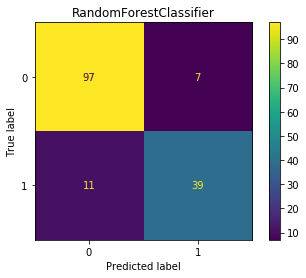

************************************************************************************************************************
AUC of LogisticRegression : 0.8892307692307692 
Accuracy of LogisticRegression : 89.23561253561253 
Precision of LogisticRegression : 77.55102040816327 
Recall of LogisticRegression : 76.0 


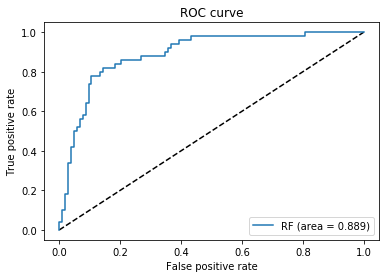

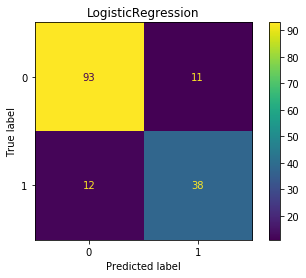

************************************************************************************************************************
AUC of KNeighborsClassifier : 0.8913461538461538 
Accuracy of KNeighborsClassifier : 88.73133903133903 
Precision of KNeighborsClassifier : 80.0 
Recall of KNeighborsClassifier : 72.0 


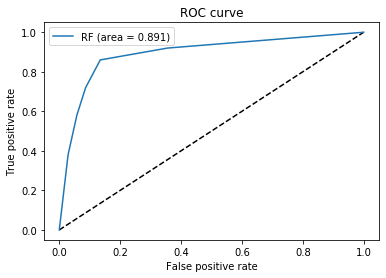

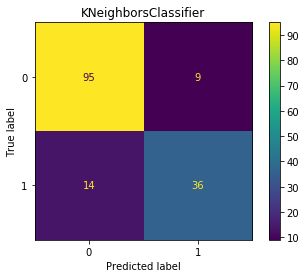

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of lab

[19:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
************************************************************************************************************************
AUC of XGBClassifier : 0.9573076923076923 
Accuracy of XGBClassifier : 95.03646723646725 
Precision of XGBClassifier : 89.36170212765957 
Recall of XGBClassifier : 84.0 


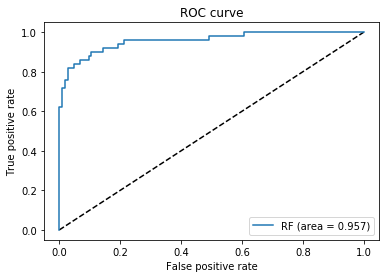

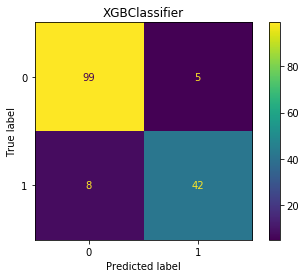

************************************************************************************************************************
AUC of GaussianNB : 0.8973076923076923 
Accuracy of GaussianNB : 88.60911680911683 
Precision of GaussianNB : 73.21428571428571 
Recall of GaussianNB : 82.0 


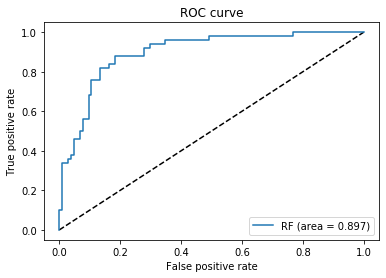

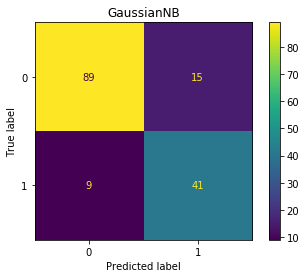

In [13]:
list_of_algo=[SVC(probability=True),AdaBoostClassifier(), RandomForestClassifier(),
              LogisticRegression(),KNeighborsClassifier(),XGBClassifier(),GaussianNB()]

name_of_algo=["SVM","AdaBoostClassifier", "RandomForestClassifier",
              "LogisticRegression","KNeighborsClassifier","XGBClassifier","GaussianNB"]

for i,algorithm in enumerate(list_of_algo):
    model=algorithm
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    model_score=cross_val_score(model,X,y,cv=10,scoring="roc_auc")
    
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_model = auc(fpr, tpr)
    print("*"*120)
    print('AUC of {} : {} '.format(name_of_algo[i],(auc_model)))
    print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))
    print('Precision of {} : {} '.format(name_of_algo[i],(precision_score(y_test,y_pred)*100)))
    print('Recall of {} : {} '.format(name_of_algo[i],(recall_score(y_test,y_pred)*100)))
    plot_auc(fpr,tpr,auc_model)
    plot_confusion_matrix(model, X_test, y_test,values_format="d")
    plt.title(name_of_algo[i])
    plt.show()    

In [78]:
"""from sklearn.model_selection import GridSearchCV
print(RandomForestClassifier())
n_estimators = [100, 200, 250, 300, 350]
max_depth = [1, 3, 4, 5, 8, 10]
min_samples_split = [10, 15, 20, 25, 30, 100]
min_samples_leaf = [1, 2, 4, 5, 7] 
max_features = ['auto', 'sqrt']
criterion=['gini']
bootstrap = [True, False]
rfr=RandomForestClassifier()
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,criterion=criterion,
              max_features = max_features,  min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,bootstrap = bootstrap)

gridF = GridSearchCV(rfr, hyperF,scoring='accuracy', cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)"""
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
param_grid = {
    'n_estimators': [100,200,300,],
    'colsample_bytree': [0.5,0.6,0.7],
    'max_depth': [3,5,8],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.8, 0.9,1,1.1],
    'gamma':[1.4,1.5,1.6,]
}
gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=10, 
        n_jobs=-1, 
        scoring="roc_auc",
        verbose=2
    )
gsf=gs.fit(X_train,y_train)
print(gsf.best_params_)

Fitting 10 folds for each of 2916 candidates, totalling 29160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 650 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 1594 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 2058 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2777 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3600 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4921 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 5764 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6804 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 8480 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 9685 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 11634 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 13001 tasks     

[13:42:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.5, 'gamma': 1.5, 'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 1}


In [40]:
#print(gsf.best_params_)
#forestOpt = RandomForestClassifier(n_estimators = 100,criterion='gini',bootstrap= False,max_depth= 3,max_features='auto'
 #                                 ,min_samples_leaf= 4)
forestOpt = RandomForestClassifier(n_estimators = 100,criterion='gini',bootstrap= False,max_depth= 3,max_features='auto'
                                  ,min_samples_leaf= 4,random_state=6)
modelfit = XGBClassifier(colsample_bytree = 0.5,max_depth = 8,n_estimators=100,reg_alpha=1.1,reg_lambda=1.1, subsample=1,gamma=1.5)
modelfit.fit(X_train,y_train)
modelOpt = forestOpt.fit(X_train, y_train)
model_score=cross_val_score(modelfit,X,y,cv=10,scoring="roc_auc")
y_pred = modelOpt.predict(X_test)
print(modelfit.score(X_test,y_test))
print("score",model_score.mean())
print(*model_score)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8831168831168831
score 0.9595897435897435
0.971111111111111 0.9496296296296296 0.9303703703703704 0.9674074074074074 0.9259259259259259 0.9733333333333334 0.9674074074074074 0.9814814814814815 0.953076923076923 0.9761538461538461


Epoch 1/200
77/77 [==============================] - 0s 2ms/step - loss: 0.5650 - accuracy: 0.7362
Epoch 2/200
77/77 [==============================] - 0s 2ms/step - loss: 0.4078 - accuracy: 0.8371
Epoch 3/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3770 - accuracy: 0.8534
Epoch 4/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3604 - accuracy: 0.8616
Epoch 5/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.8616
Epoch 6/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3434 - accuracy: 0.8681
Epoch 7/200
77/77 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.8681
Epoch 8/200
77/77 [==============================] - 0s 3ms/step - loss: 0.3267 - accuracy: 0.8746
Epoch 9/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3194 - accuracy: 0.8746
Epoch 10/200
77/77 [==============================] - 0s 3ms/step - loss: 0.3134 - accuracy: 0.8746
Epoch 11/

77/77 [==============================] - 0s 3ms/step - loss: 0.1581 - accuracy: 0.9772
Epoch 162/200
77/77 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.9642
Epoch 163/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0772 - accuracy: 0.9788
Epoch 164/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0402 - accuracy: 0.9853
Epoch 165/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9951
Epoch 166/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0133 - accuracy: 0.9967
Epoch 167/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.9951
Epoch 168/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0119 - accuracy: 0.9967
Epoch 169/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0105 - accuracy: 0.9984
Epoch 170/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0122 - accuracy: 0.9967
Epoc

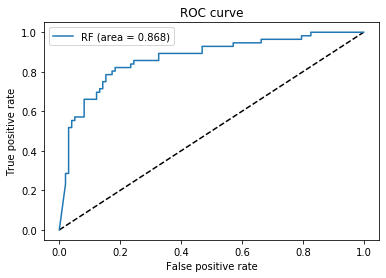

In [67]:

##Build an model(Neural model )
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fit=model.fit(X_train, y_train, epochs=200, batch_size=8)
_, nn_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_nn = auc(fpr, tpr)
plot_auc(fpr,tpr,auc_nn)



In [41]:
import pickle
# Save trained model to file
pickle.dump(modelfit, open("Diabetes.pkl", "wb"))
loaded_model = pickle.load(open("Diabetes.pkl", "rb"))
loaded_model.predict(X_test)
loaded_model.score(X_test,y_test)

0.8831168831168831